In [ ]:
from pystac_client import Client
import geopandas as gpd
from datetime import datetime, UTC
import stackstac
import xarray as xr
from shapely.geometry import Point
from rasterio.errors import RasterioIOError
from planetary_computer import sign_inplace
import matplotlib.pyplot as plt
import sentinel2indices as s2i
from skimage.exposure import match_histograms
import math
from dask.diagnostics import ProgressBar
import rioxarray
import os

<Axes: >

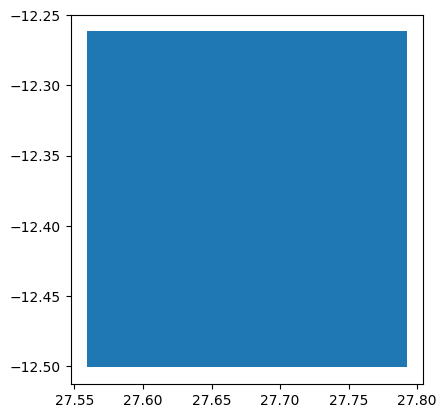

In [2]:
### Load Data

# Connect to Planetary Computer STAC
stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Load AOI from GeoJSON file
aoi_path = '/Users/thowe/MinersAI Dropbox/Tyler Howe/Archive/KoboldData/zambia_aoi_small.geojson'
aoi_gdf = gpd.read_file(aoi_path)

# Reproject to WGS84 if needed
if aoi_gdf.crs != "EPSG:4326":
    aoi_gdf = aoi_gdf.to_crs("EPSG:4326")

aoi_gdf.plot()

In [3]:
### Search STAC for low-cloud Sentinel-2 L2A items over AOI

# Broad date range — Sentinel-2 L2A available since mid-2017
start_date = "2017-06-28"
end_date = datetime.now(UTC).date().isoformat()

# Query STAC for clean Sentinel-2 L2A items
search = stac.search(
    collections=["sentinel-2-l2a"],
    intersects=aoi_gdf.geometry[0].__geo_interface__,
    datetime=f"{start_date}/{end_date}",
    query={"eo:cloud_cover": {"lt": 10}},  # low-cloud only
    sortby=["eo:cloud_cover"],  # sort by best quality
)

items = list(search.items())
print(f"Found {len(items)} items")

# Print out all property keys on the first item to view available metadata
props = items[0].properties
for k in sorted(props):
    print(k)

Found 300 items
constellation
datetime
eo:cloud_cover
instruments
platform
proj:code
s2:cloud_shadow_percentage
s2:datastrip_id
s2:datatake_id
s2:datatake_type
s2:degraded_msi_data_percentage
s2:generation_time
s2:granule_id
s2:high_proba_clouds_percentage
s2:mean_solar_azimuth
s2:mean_solar_zenith
s2:medium_proba_clouds_percentage
s2:mgrs_tile
s2:nodata_pixel_percentage
s2:not_vegetated_percentage
s2:processing_baseline
s2:product_type
s2:product_uri
s2:reflectance_conversion_factor
s2:saturated_defective_pixel_percentage
s2:snow_ice_percentage
s2:thin_cirrus_percentage
s2:unclassified_percentage
s2:vegetation_percentage
s2:water_percentage
sat:orbit_state
sat:relative_orbit


In [4]:
### Filter for S2A scenes, set EPSG, and stack selected bands at 10m resolution

# Keep only S2A scenes (from all items) and sign their URLs
s2a_items = [it for it in items if it.id.startswith("S2A")][:20]
if not s2a_items:
    raise RuntimeError("No S2A scenes found—check your STAC search criteria.")
for it in s2a_items:
    sign_inplace(it)
print("Using these S2A items:", [it.id for it in s2a_items])

# Try EPSG from first item
item0 = s2a_items[0]
epsg = None
try:
    epsg = item0.assets["B02"].extra_fields["proj:epsg"]
    print(f"Using EPSG from first item: {epsg}")
except KeyError:
    pass

# Fall back to AOI centroid
if epsg is None:
    centroid: Point = aoi_gdf.geometry[0].centroid
    lon, lat = centroid.x, centroid.y
    zone = int((lon + 180) / 6) + 1
    epsg = 32600 + zone if lat >= 0 else 32700 + zone
    print(f"Using EPSG from AOI centroid: {epsg}")

# Stack normally, resolution=10m for all bands
stack = stackstac.stack(
    s2a_items,
    assets=["B01", "B02", "B03", "B04", "B08", "B8A", "B11", "B12", "SCL"],
    resolution=10,  # 10m resolution for all bands
    epsg=epsg,
    chunksize=2048,
    bounds_latlon=aoi_gdf.total_bounds,
    dtype="float64",
    rescale=True,
    errors_as_nodata=[RasterioIOError, RuntimeError],
)

stack

Using these S2A items: ['S2A_MSIL2A_20241008T080831_R078_T35LNG_20241008T121151', 'S2A_MSIL2A_20240908T080611_R078_T35LNG_20240908T142348', 'S2A_MSIL2A_20240829T080601_R078_T35LNG_20240829T125422', 'S2A_MSIL2A_20240819T080611_R078_T35LNG_20240819T130750', 'S2A_MSIL2A_20240809T080611_R078_T35LNG_20240809T145755', 'S2A_MSIL2A_20240720T080611_R078_T35LNG_20240720T133231', 'S2A_MSIL2A_20240710T080611_R078_T35LNG_20240710T151222', 'S2A_MSIL2A_20240630T080611_R078_T35LNG_20240701T190652', 'S2A_MSIL2A_20240620T080611_R078_T35LNG_20240620T140208', 'S2A_MSIL2A_20240531T080611_R078_T35LNG_20240531T150458', 'S2A_MSIL2A_20230924T080651_R078_T35LNG_20230924T141335', 'S2A_MSIL2A_20230904T080611_R078_T35LNG_20241104T133156', 'S2A_MSIL2A_20230904T080611_R078_T35LNG_20230904T173507', 'S2A_MSIL2A_20230825T080611_R078_T35LNG_20241026T184312', 'S2A_MSIL2A_20230825T080611_R078_T35LNG_20230825T162213', 'S2A_MSIL2A_20230815T080611_R078_T35LNG_20230815T171601', 'S2A_MSIL2A_20230805T080611_R078_T35LNG_20241026

<xarray.DataArray 'stackstac-3d1ea0ef2de1f3d3e9a498ee330ba35d' (time: 20,
                                                                band: 9,
                                                                y: 2655, x: 2545)> Size: 10GB
dask.array<fetch_raster_window, shape=(20, 9, 2655, 2545), dtype=float64, chunksize=(1, 1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 160B 2023-...
    id                                       (time) <U54 4kB 'S2A_MSIL2A_2023...
  * band                                     (band) <U3 108B 'B01' ... 'SCL'
  * x                                        (x) float64 20kB 5.607e+05 ... 5...
  * y                                        (y) float64 21kB 8.644e+06 ... 8...
    s2:processing_baseline                   (time) <U5 400B '05.09' ... '05.11'
    ...                                       ...
    proj:bbox                                object 8B {8590240.0, 8700040.0,...
    title                                    (band) <U37 1kB 'Band 1 - Coasta...
    common_name                              (band) object 72B 'coastal' ... ...
    center_wavelength                        (band) object 72B 0.443 ... None
    full_width_half_max                      (band) object 72B 0.027 ... None
    epsg                                     int64 8B 32735
Attributes:
    spec:        RasterSpec(epsg=32735, bounds=(560740, 8617920, 586190, 8644...
    crs:         epsg:32735
    transform:   | 10.00, 0.00, 560740.00|\n| 0.00,-10.00, 8644470.00|\n| 0.0...
    resolution:  10

In [5]:
# Histogram‐match with dask_gufunc_kwargs

# Rechunk so band, y, x are single chunks
stack_small = stack.chunk({"band": -1, "y": -1, "x": -1})

### Reference = first clean scene (no time dim)

# 2. pick all the reflectance bands (no SCL)
ref_bands = ["B01", "B02", "B03", "B04", "B08", "B8A", "B11", "B12"]
ref = stack_small.isel(time=0).sel(band=ref_bands).chunk({"band": -1, "y": -1, "x": -1})


def match_to_ref(scene, ref):
    return xr.apply_ufunc(
        match_histograms,
        scene,
        ref,
        input_core_dims=[["band", "y", "x"], ["band", "y", "x"]],
        output_core_dims=[["band", "y", "x"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[scene.dtype],
        dask_gufunc_kwargs={
            "allow_rechunk": True,
            "output_sizes": {
                "band": scene.sizes["band"],
                "y": scene.sizes["y"],
                "x": scene.sizes["x"],
            },
        },
    )


# Build the normalized stack, re-adding time
matched = []
for i, t in enumerate(stack_small.time.values):
    scene = stack_small.isel(time=i).sel(band=ref.band)
    scene = scene.chunk({"band": -1, "y": -1, "x": -1})
    m = match_to_ref(scene, ref)
    m = m.expand_dims(time=[t])
    matched.append(m)


stack_norm = xr.concat(matched, dim="time")

In [6]:
### Mask invalid pixels using SCL and compute median composite over time

# Ensure your original stack is rechunked so SCL aligns
stack_small = stack.chunk({"band": -1, "y": -1, "x": -1})

# Extract the Scene Classification Layer and build a “valid” mask
scl = stack_small.sel(band="SCL")
valid = scl.isin([4, 5, 6])  # vegetation=4, bare soil=5, water=6

# Apply mask to the histogram-matched reflectance and composite

clean = stack_norm.where(valid)       # holds only the reflectance bands (no SCL)
composite = clean.median(dim="time")

# Inspect the composite
composite

<xarray.DataArray 'stackstac-3d1ea0ef2de1f3d3e9a498ee330ba35d' (band: 8,
                                                                y: 2655, x: 2545)> Size: 432MB
dask.array<nanmedian, shape=(8, 2655, 2545), dtype=float64, chunksize=(1, 935, 896), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * band                                     (band) <U3 96B 'B01' ... 'B12'
  * x                                        (x) float64 20kB 5.607e+05 ... 5...
  * y                                        (y) float64 21kB 8.644e+06 ... 8...
    proj:code                                <U10 40B 'EPSG:32735'
    sat:orbit_state                          <U10 40B 'descending'
    s2:mgrs_tile                             <U5 20B '35LNG'
    ...                                       ...
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:snow_ice_percentage                   float64 8B 0.0
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    proj:bbox                                object 8B {8590240.0, 8700040.0,...
    epsg                                     int64 8B 32735

In [ ]:
### Calculate spectral indices

# list out each function you want to try
funcs = [
    s2i.hematite_goethite_s2, 
    s2i.hematite_jarosite_s2, 
    s2i.mixed_iron_s2
]


results = []
for fn in funcs:
    da = fn(composite)
    da = da.rename(fn.__name__)
    results.append(da)

# 2) concat
indices = xr.concat(results, dim="band")

# 3) load & attach CRS
with ProgressBar():
    loaded = indices.compute().rio.write_crs(f"EPSG:{epsg}")

[########################################] | 100% Completed | 22m 14s


TypeError: argument of type 'numpy.int64' is not iterable

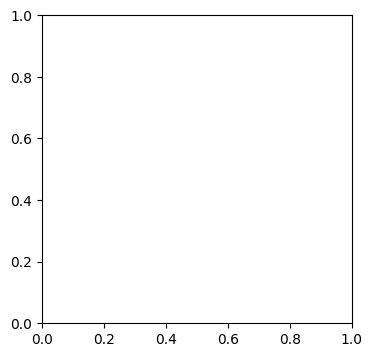

In [12]:
### Plot the results

bands = list(loaded.band.values)
n = len(bands)
ncols = min(4, n)
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), squeeze=False)

for i, band in enumerate(bands):
    ax = axes.flat[i]
    da = loaded.sel(band=band)

    cmap = ("terrain" if "clay" in band
            else "RdBu"   if "iron" in band
            else "viridis")

    arr = da.squeeze().values
    im = da.plot.imshow(
        ax=ax,
        cmap=cmap,
        add_colorbar=False,
        add_labels=False,   
        origin="upper"
    )
    cbar = fig.colorbar(im, ax=ax,
                        orientation="vertical",
                        fraction=0.046, pad=0.04)
    cbar.set_label(band.replace("_"," ").title())
    ax.set_title(band.replace("_"," ").title())
    ax.axis("off")

# disable any empty subplots
for j in range(n, nrows * ncols):
    r, c = divmod(j, ncols)
    axes[r][c].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
### Export the results

index_names = list(loaded.band.values)
print("Will export these indices:", index_names)


output_dir = '/Users/thowe/Downloads'
os.makedirs(output_dir, exist_ok=True)

# loop through names and export
for name in index_names:
    da = loaded.sel(band=name)
    da.rio.to_raster(os.path.join(output_dir, f"{name}.tif"))

-----------------
-------------------
---------------------

In [ ]:
# Compute clay and iron oxide indices from composite bands

# Select bands
b04 = composite.sel(band="B04")
b11 = composite.sel(band="B11")
b12 = composite.sel(band="B12")

# Compute indices
clay_index = (b12 / b11).rename("clay_index")
iron_index = ((b04 - b11) / (b04 + b11)).rename("iron_index")

# Combine into one DataArray
indices = xr.concat([clay_index, iron_index], dim="band")
indices["band"] = ["clay_index", "iron_index"]

# Inspect
indices

In [ ]:
# Load clay and iron index arrays fully into memory for plotting

clay = indices.sel(band="clay_index").compute()
iron = indices.sel(band="iron_index").compute()

In [ ]:
# Plot the clay index
clay.plot(
    cmap="terrain",
    cbar_kwargs={"label": "Clay Index"},
)
plt.title("Clay Index")
plt.axis("off")


In [ ]:
# Plot the iron oxide index
iron.plot(
    cmap="RdBu",
    cbar_kwargs={"label": "Iron Oxide Index"},
)
plt.title("Iron Oxide Index")
plt.axis("off")